In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import os
import zipfile

In [2]:
!pip install kaggle
# Upload your Kaggle API credentials JSON file
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Download the dataset from Kaggle
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

Saving kaggle.json to kaggle.json
 93% 110M/119M [00:00<00:00, 201MB/s] 
100% 119M/119M [00:00<00:00, 187MB/s]


In [3]:
with zipfile.ZipFile("chest-ctscan-images.zip", "r") as zip_ref:
    zip_ref.extractall("/content/chest-ctscan-images")

In [4]:
import numpy as np
import cv2
import os
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Function to load the dataset
def load_dataset(dataset_folder_path):
    data = []
    labels = []
    label_to_int = {}  # Dictionary to map labels to integers
    int_label = 0
    for folder_name in os.listdir(dataset_folder_path):
        if folder_name not in label_to_int:
            label_to_int[folder_name] = int_label
            int_label += 1
        folder_path = os.path.join(dataset_folder_path, folder_name)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))  # googlenet input size
            data.append(image)
            labels.append(folder_name)
    # Convert the lists to numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    return data, labels, label_to_int
# Load the test dataset
test_dataset_path = "/content/chest-ctscan-images/Data/test/"
test_data, test_labels, label_to_int = load_dataset(test_dataset_path)

# Load the train dataset
train_dataset_path = "/content/chest-ctscan-images/Data/train/"
train_data, train_labels, label_to_int = load_dataset(train_dataset_path)

# Load the validation dataset
valid_dataset_path = "/content/chest-ctscan-images/Data/valid/"
valid_data, valid_labels, label_to_int = load_dataset(valid_dataset_path)

# Shuffle the datasets
train_data, train_labels = shuffle(train_data, train_labels, random_state=42)
test_data, test_labels = shuffle(test_data, test_labels, random_state=42)
valid_data, valid_labels = shuffle(valid_data, valid_labels, random_state=42)

# Normalize the pixel values to [0, 1]
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0
valid_data = valid_data.astype('float32') / 255.0

# Convert the labels to integers using label_to_int dictionary
train_labels_mapped = np.array([label_to_int[label] for label in train_labels])
# Convert the labels to integers using label_to_int dictionary
train_labels_mapped = np.array([label_to_int[label] for label in train_labels])

# Convert the labels to integers using label_to_int dictionary
test_labels_mapped = []
for label in test_labels:
    if label in label_to_int:
        test_labels_mapped.append(label_to_int[label])
    else:
        # Handle missing or unexpected labels (e.g., assign a unique integer or skip the sample)
        # You can also ignore the sample if needed.
        pass

test_labels_mapped = np.array(test_labels_mapped)
# Convert the labels to integers using label_to_int dictionary
valid_labels_mapped = np.array([label_to_int[label] for label in valid_labels])
valid_labels_mapped = np.array([label_to_int[label] for label in valid_labels])
# Convert the labels to one-hot encoded vectors
num_classes = len(label_to_int)
train_labels = tf.keras.utils.to_categorical(train_labels_mapped, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels_mapped, num_classes)
valid_labels = tf.keras.utils.to_categorical(valid_labels_mapped, num_classes)
# Rest of the code for building, training, and evaluating the model...

In [5]:
from sklearn.model_selection import train_test_split
# Split the original training dataset into new training and test datasets
new_train_data, new_test_data, new_train_labels, new_test_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42
)
# Combine the new training and test datasets
combined_data = np.concatenate((new_train_data, new_test_data), axis=0)
combined_labels = np.concatenate((new_train_labels, new_test_labels), axis=0)

# Shuffle the combined dataset
combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=42)

# Split the shuffled dataset into final training and test datasets
train_data, test_data, train_labels, test_labels = train_test_split(
    combined_data, combined_labels, test_size=0.2, random_state=42
)

# Print the sizes of the final datasets
print("Final training dataset size:", len(train_data))
print("Final test dataset size:", len(test_data))

Final training dataset size: 490
Final test dataset size: 123


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the AlexNet model
def create_alexnet_model(input_shape, num_classes):
    model = Sequential()

    # Layer 1: Convolutional Layer
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 2: Convolutional Layer
    model.add(Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 3: Convolutional Layer
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))

    # Layer 4: Convolutional Layer
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))

    # Layer 5: Convolutional Layer
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 6: Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Layer 7: Fully Connected Layer
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Assuming input images are RGB with size 224x224
input_shape = (224, 224, 3)
num_classes = 4  # Replace with the actual number of classes

# Create the AlexNet model
alexnet_model = create_alexnet_model(input_shape, num_classes)

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
alexnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
alexnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

In [8]:
print(len(train_data), len(train_labels))
print(len(test_data), len(test_labels))
print(len(valid_data), len(valid_labels))

490 490
123 123
72 72


In [22]:
# Training the model
batch_size = 32
epochs = 1
history = alexnet_model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_data, test_labels))
# Save the fine-tuned model to a file
model_save_path = "my_fine_tuned_alexnet_model.h5"
alexnet_model.save(model_save_path)

16/16 [==============================] - 1s 56ms/step - loss: 1.3496 - accuracy: 0.3265 - val_loss: 1.2797 - val_accuracy: 0.2764


In [23]:
test_loss, test_accuracy = alexnet_model.evaluate(test_data, test_labels, batch_size=batch_size)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

4/4 [==============================] - 0s 24ms/step - loss: 1.2797 - accuracy: 0.2764
Test Loss: 1.2797266244888306
Test Accuracy: 0.27642276883125305


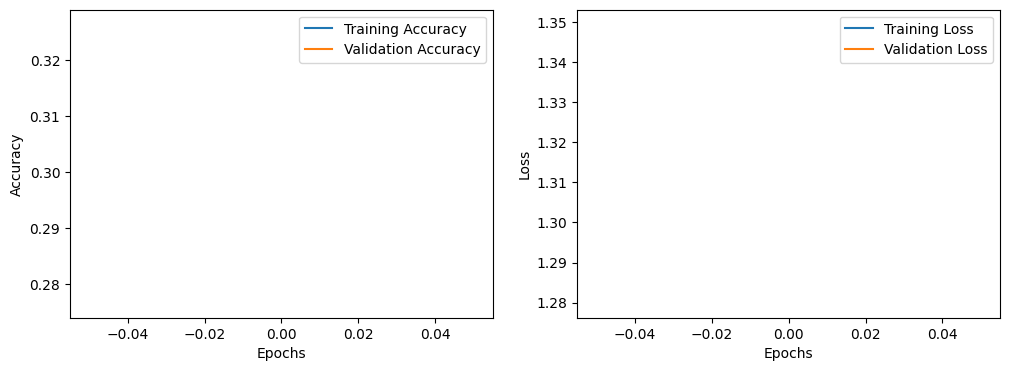

In [24]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# Plot the training history
plot_history(history)

4/4 [==============================] - 0s 20ms/step


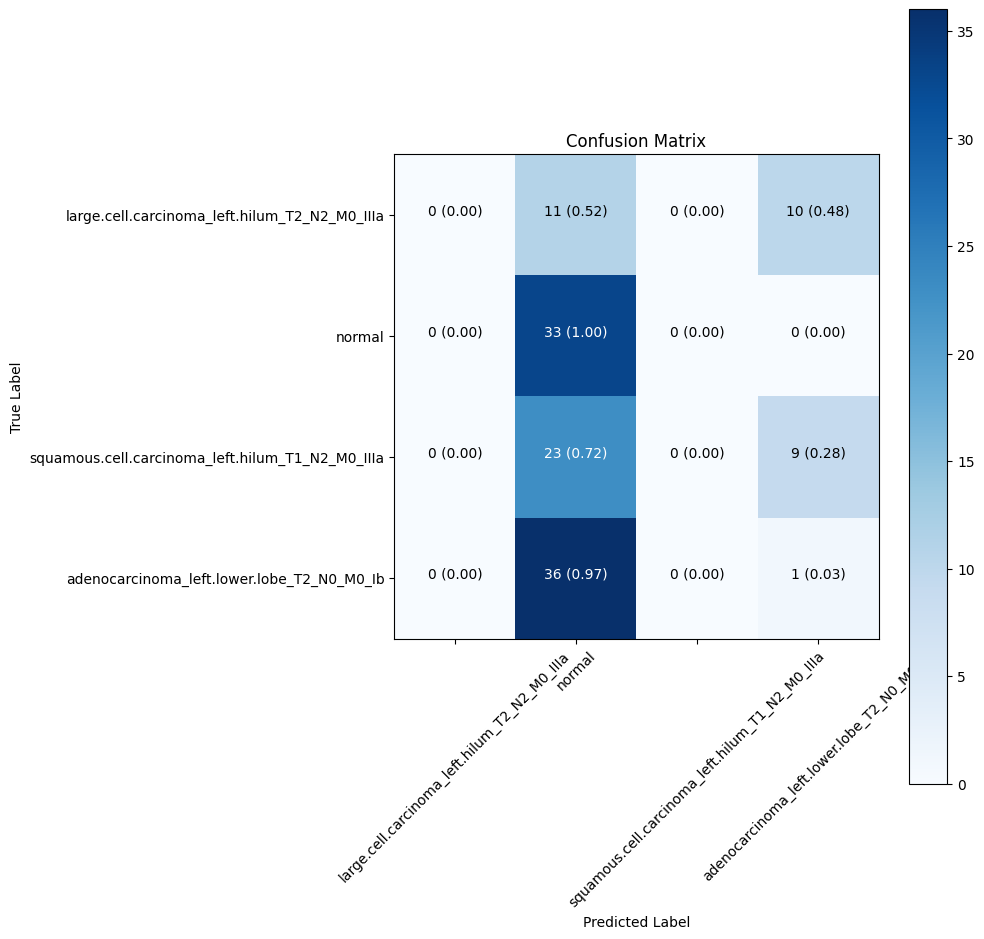

In [25]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Assuming you have already trained your vgg19_model and obtained predictions on the test set
predictions = alexnet_model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)

# Get class labels from the label_to_int dictionary
label_to_int_inv = {v: k for k, v in label_to_int.items()}
classes = [label_to_int_inv[i] for i in range(num_classes)]

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Normalize the confusion matrix values for better readability
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Use white text for darker cells, and black text otherwise
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd') + " (" + format(cm_normalized[i, j], '.2f') + ")",
             horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [26]:
from sklearn.metrics import accuracy_score
# Assuming you have already trained your model and obtained predictions on the test set
# predictions = model.predict(test_data)
# predicted_labels = np.argmax(predictions, axis=1)
# Compute the accuracy
accuracy = accuracy_score(np.argmax(test_labels, axis=1), predicted_labels)
# Display the accuracy percentage
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 27.64%


In [27]:
from sklearn.metrics import classification_report
# Assuming you have already trained your model and obtained predictions on the test set
# predictions = model.predict(test_data)
# predicted_labels = np.argmax(predictions, axis=1)
# Compute the classification report
report = classification_report(np.argmax(test_labels, axis=1), predicted_labels)
# Display the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.32      1.00      0.49        33
           2       0.00      0.00      0.00        32
           3       0.05      0.03      0.04        37

    accuracy                           0.28       123
   macro avg       0.09      0.26      0.13       123
weighted avg       0.10      0.28      0.14       123



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')
recall = recall_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')
f1 = f1_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

Precision: 0.10
Recall: 0.28
F1-Score: 0.14


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


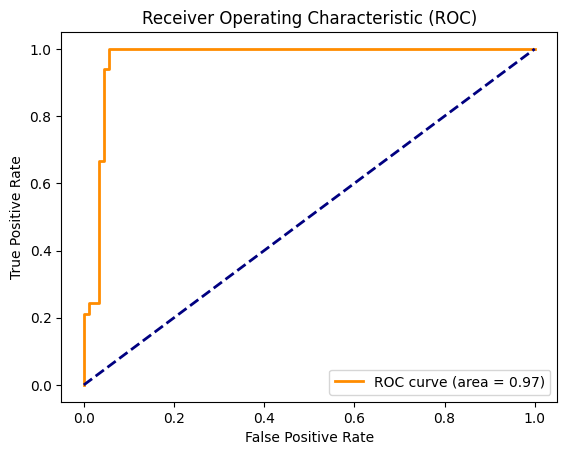

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Assuming binary classification (two classes) for simplicity
# If your problem is multi-class, you need to modify the code accordingly
fpr, tpr, thresholds = roc_curve(test_labels[:, 1], predictions[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

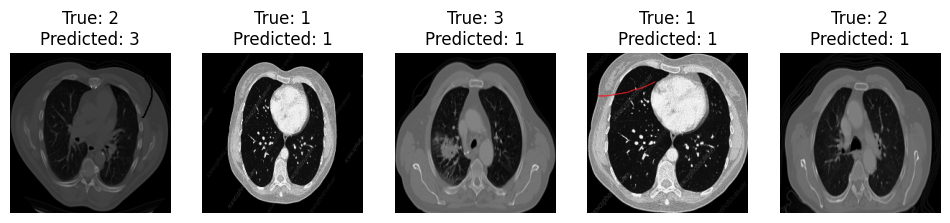

In [30]:
import random
# Assuming you have already trained your model and obtained predictions on the test set
# predictions = model.predict(test_data)
# predicted_labels = np.argmax(predictions, axis=1)
# Choose a random subset of test data and corresponding true and predicted labels
random_indices = random.sample(range(len(test_data)), 5)
sample_images = test_data[random_indices]
sample_true_labels = np.argmax(test_labels[random_indices], axis=1)
sample_predicted_labels = predicted_labels[random_indices]
# Visualize the sample images with true and predicted labels
plt.figure(figsize=(12, 6))
for i in range(len(sample_images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_true_labels[i]}\nPredicted: {sample_predicted_labels[i]}")
    plt.axis('off')
plt.show()

include_top=False argument ensures that the top classification layers of VGG19 are not included,so you can add your own custom layers later.output of the VGG19 model is fed into a Flatten() layer to convert the 4D tensor into a 2D tensor.two fully connected (Dense) layers with 4096 units and ReLU activation are added.the output layer with num_classes units and a softmax activation function is added where num_classes is the number of classes in your dataset.you freeze the pre-trained layers of the VGG19 model to avoid overfitting on your limited dataset. In this step, the model is compiled with the Adam optimizer using a lower learning rate (0.0001) for fine-tuning .

In [33]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the fine-tuned VGG19 model
model_path = "/content/my_fine_tuned_alexnet_model.h5"  # Replace with the actual path of your model
fine_tuned_model = load_model(model_path)

# Function to preprocess the input image
def preprocess_input_image(image_path, input_shape):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, input_shape)  # Resize to match the model's input dimensions
    image = image.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add a batch dimension
    return image

# Function to get the predicted class label based on label_to_int dictionary
def get_predicted_label(predictions, label_to_int):
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = list(label_to_int.keys())[list(label_to_int.values()).index(predicted_class)]
    return predicted_label

# Define the label_to_int dictionary to map class labels to integers
label_to_int = {
     "adenocarcinoma":0,
    "large Cell carcinoma":1,
    "normal": 2,
     "squamous.cell.carcinoma":3
}

# Ask the user to upload an image
print("Please upload a CT scan image:")
uploaded_files = files.upload()

# Get the file path of the uploaded image
input_image_path = list(uploaded_files.keys())[0]

# Preprocess the input image
input_shape = (224, 224)  # VGG19 model input dimensions
input_image = preprocess_input_image(input_image_path, input_shape)

# Use the fine-tuned VGG19 model to predict the class of the input image
predictions = fine_tuned_model.predict(input_image)

# Get the predicted class label based on label_to_int dictionary
predicted_label = get_predicted_label(predictions, label_to_int)

# Determine whether the input image has lung cancer or not
lung_cancer_classes = ["squamous.cell.carcinoma", "large Cell carcinoma", "adenocarcinoma"]
if predicted_label in lung_cancer_classes:
    print("The input image has lung cancer.")
    print("Class of lung cancer:", predicted_label)
else:
    print("The input image does not have lung cancer. It is classified as:", predicted_label)



Please upload a CT scan image:


Saving 000066 - Copy.png to 000066 - Copy.png
1/1 [==============================] - 0s 358ms/step
The input image has lung cancer.
Class of lung cancer: large Cell carcinoma
